# Inference

Testing the inference API

In [1]:
from glob import glob
import random
import rasterio as rio
import numpy as np
import requests
import matplotlib.pyplot as plt
import io
import json
from matplotlib.colors import ListedColormap
from PIL import Image

In [2]:
images = glob('data/*_TOA.tif')

In [5]:
sample = random.choice(images)
sample

'data/20221106_191522_SN24_11N_378491_3779282_TOA.tif'

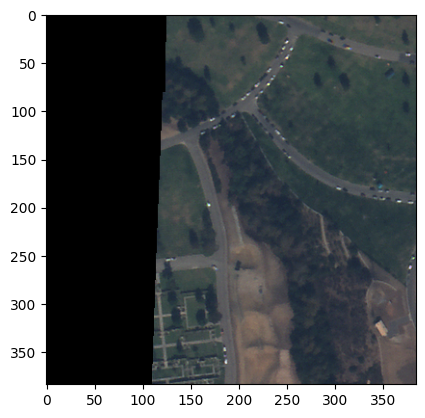

In [6]:
ds = rio.open(sample)
rgb = (ds.read([1, 2, 3]) / 4000).clip(0, 1)
plt.imshow(rgb.transpose(1, 2, 0))
plt.show()

In [8]:
url = 'http://localhost:8001/classification/classification.onnx'

res = requests.post(url, files={'image': open(sample, 'rb')})
if res.status_code != 200:
	print(res.json())

outputs = res.json()
outputs

[0.0422399640083313,
 0.45387181639671326,
 0.10651576519012451,
 0.03650575876235962,
 0.34744876623153687,
 0.09297001361846924]

In [25]:
url = 'http://localhost:8001/segmentation/segmentation.onnx'

res = requests.post(url, files={'image': open(sample, 'rb')})
if res.status_code != 200:
    print(res.json())

# Read the response content as a TIFF file
with rio.open(io.BytesIO(res.content)) as src:
    array = src.read()
array.shape

(16, 384, 384)

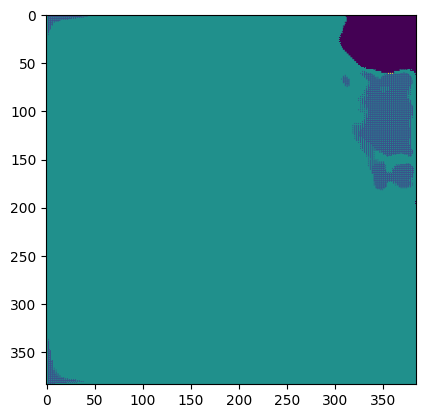

In [26]:
# keep largest class

mask = np.argmax(array, axis=0) + 1

plt.imshow(mask)

In [19]:
with open('data/spai.json', 'r') as f:
    data = json.load(f)

data

{'labels': [{'name': 'bare-soil', 'color': '#e2e600'},
  {'name': 'water', 'color': '#0040ff'},
  {'name': 'forest', 'color': '#04ff00'},
  {'name': 'agriculture', 'color': '#00ffb3'},
  {'name': 'urban', 'color': '#ff0000'}]}

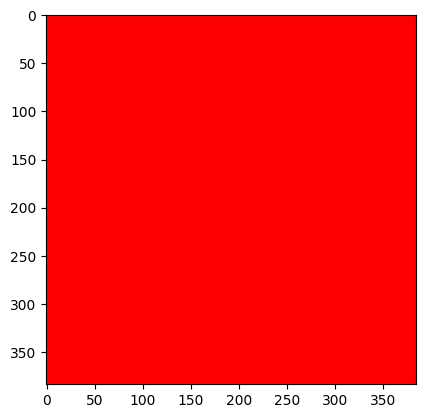

In [27]:
colors = ['#000000'] + [label['color'] for label in data['labels']]
cmap = ListedColormap(colors)

plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(colors))
plt.show()